In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%reset -f

In [2]:
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
from yellowbrick.regressor import residuals_plot

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

from scipy import stats
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import time

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn import ensemble

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import unique_labels
import tensorflow as tf

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Far-Field Ground Motion (Baker + Northridge)

## Load data

In [3]:
# Load data
## 120 record from Baker dataset and 150 records from Northridge
Baker_data=pd.read_csv('Result_Baker.csv',header=None)
Baker_data.columns = ['Tp','PGA','Weight','Height','K1','Q','K2','T','Q/W','Drift']
#Baker_data.head()
NR_data=pd.read_csv('Result_NR_150.csv',header=None)
NR_data.columns = ['Long','Lat','Tp','PGA','Weight','Height','K1','Q','K2','T','Q/W','Drift']
NR_data=NR_data.drop(['Long','Lat'],axis=1)
#NR_data.head()
Total_data=pd.concat([Baker_data,NR_data],axis=0)
Total_data.iloc[:,0]=1.0/Total_data.iloc[:,0]
print("Size of the dataset: {}".format(Total_data.shape))
Total_data.rename(columns={'Tp':'fp'}, inplace=True)
Total_data.head()

## delete the duplicate rows
print('Number of Total Rows:%d' %Total_data.shape[0])
Total_data.drop_duplicates(subset =["fp","PGA","Weight","Height","Drift"],keep = 'first', inplace = True) 
print('Number of Unique Rows:%d' %Total_data.shape[0])

Size of the dataset: (12150, 10)


,fp,PGA,Weight,Height,K1,Q,K2,T,Q/W,Drift
0,1.880123,2.3418,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.052296
1,1.141396,3.1611,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.079047
2,0.781616,4.0768,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.056844
3,1.715207,2.3777,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.041334
4,0.463929,2.7257,2210000.0,7.148,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.053953


Number of Total Rows:12150
Number of Unique Rows:12105


In [6]:
min(Total_data['fp'])
max(Total_data['fp'])
NR_data

0.17091971900798195

13.502565487442613

,Tp,PGA,Weight,Height,K1,Q,K2,T,Q/W,Drift
0,0.72478,0.99097,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.016090
1,0.21547,0.65973,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.004127
2,0.57676,0.72624,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.019946
3,0.30789,0.43321,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.005322
4,0.25117,0.45130,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.003950
5,0.49337,0.89103,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.015939
6,0.46011,0.89237,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.011540
7,1.16970,3.38440,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.051705
8,0.26083,0.95082,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.005365
9,0.71842,0.99589,2210000.0,7.1480,25600000.0,1090000.0,1700000.0,0.58684,0.493,0.014724


## Data Inspection

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

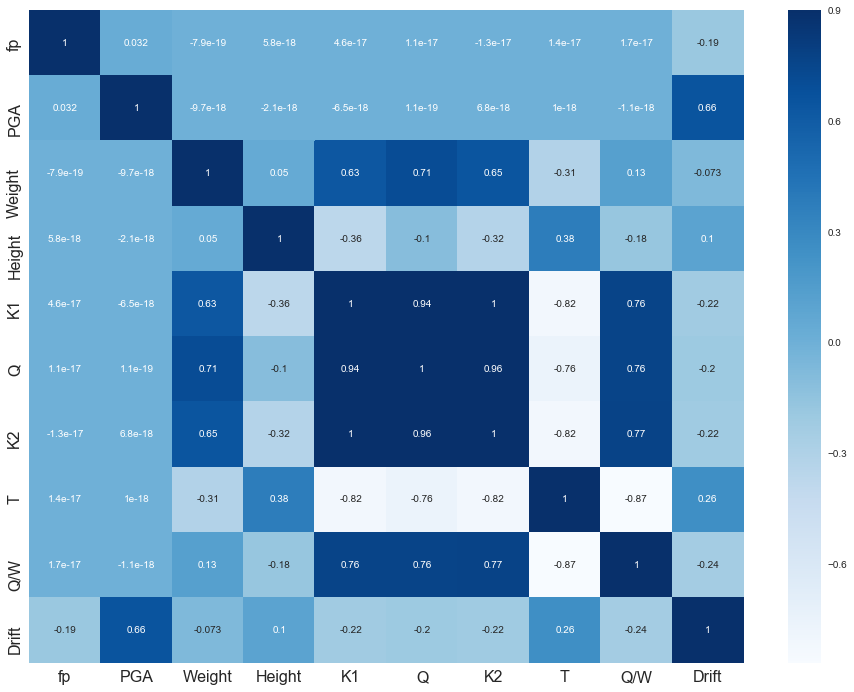

In [4]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
plt.xticks(rotation = 0,fontsize=16)
plt.yticks(fontsize=16)
#sns.heatmap(data_vp.corr(), vmax=0.9, cmap="YlGnBu" or "coolwarm", square=True, annot=True)
sns.heatmap(Total_data.corr(), vmax=0.9, cmap="Blues",  annot=True)

## Feature Selection

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$fp$ (F-test=0.05, MI=0.77)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$PGA$ (F-test=1.00, MI=1.00)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Weight$ (F-test=0.01, MI=0.05)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Height$ (F-test=0.01, MI=0.05)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K1$ (F-test=0.07, MI=0.06)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Q$ (F-test=0.06, MI=0.06)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$K2$ (F-test=0.07, MI=0.07)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$T$ (F-test=0.09, MI=0.07)')

Text(0, 0.5, '$Drift$')

Text(0.5, 1.0, '$Q/W$ (F-test=0.08, MI=0.07)')

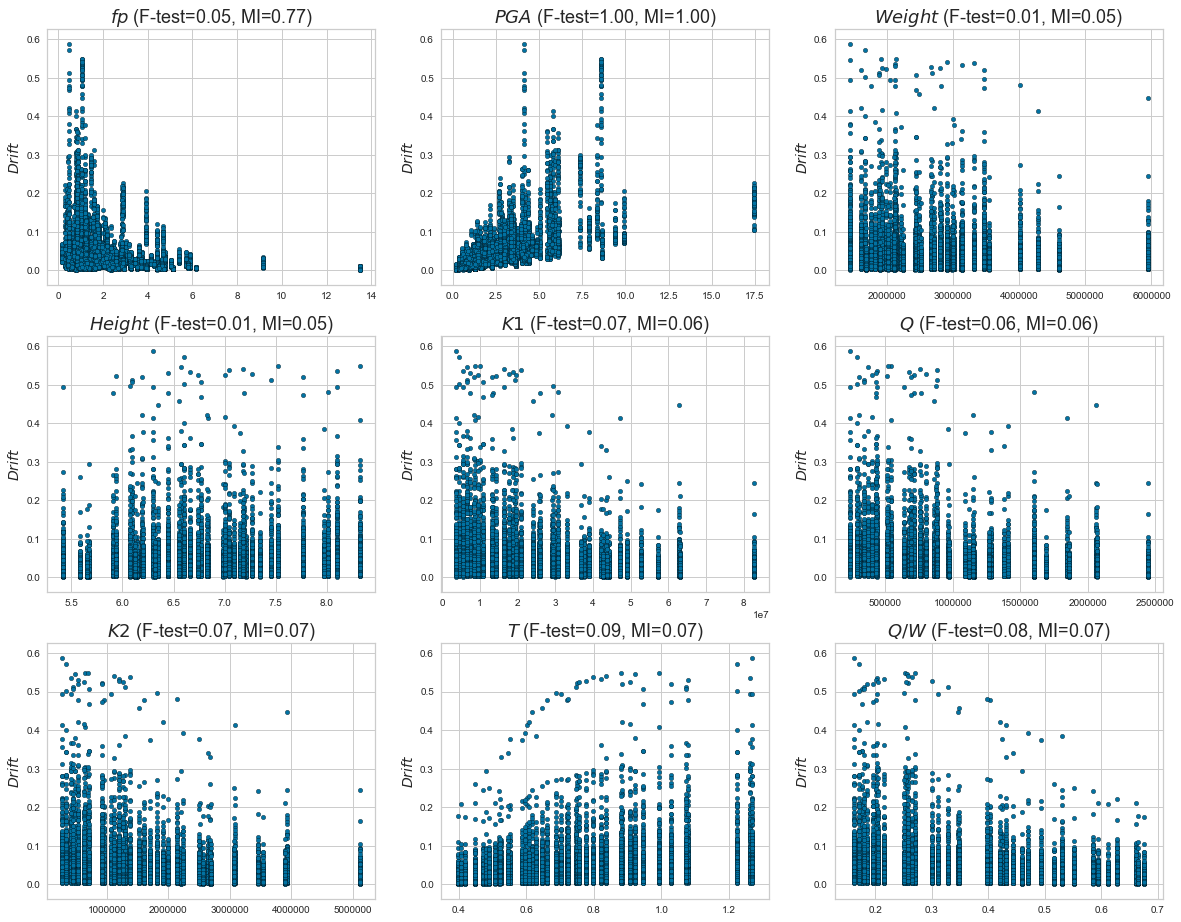

In [5]:
#selected_feature_index = [0,1,2,4,5,6,8,9,10]
f_test, _ = f_regression(Total_data.iloc[:,:9], Total_data.iloc[:,9])
f_test = f_test / np.max(f_test)
mi = mutual_info_regression(Total_data.iloc[:,:9], Total_data.iloc[:,9])
mi = mi/np.max(mi)
fig, ax = plt.subplots(3, 3, figsize=(20, 16))
for i,axes in zip(range(9),ax.flatten()):
    axes.scatter(Total_data.iloc[:,i], Total_data.iloc[:,9], edgecolor='black', s=20)
    #axes.set_xlabel("${}$".format(data_vp.columns[selected_feature_index[i]]), fontsize=14)
    axes.set_ylabel("$Drift$", fontsize=14)
    axes.set_title("${}$ (F-test={:.2f}, MI={:.2f})".format(Total_data.columns[i],f_test[i], mi[i]),
              fontsize=18)



## Regression Analysis

In [6]:
# train
#X=np.array(Total_data.drop(['Weight','Height','K1','Q','K2','Drift'],axis=1))
X=np.array(Total_data.drop(['Weight','K1','Q','K2','Drift'],axis=1))
y=Total_data.values[:,9]

X_train, X_val,y_train,y_val = train_test_split(X,y, test_size=0.2,shuffle=True)
Height_train=X_train[:,2]
Height_val=X_val[:,2]
X_train=np.delete(X_train, 2,axis=1)
X_val=np.delete(X_val, 2,axis=1)     

In [40]:
def score(model_name,y_val,y_val_pred):
    print("The calculated RMSE for "+model_name+" is:%0.8f" % (sqrt(mean_squared_error(y_val, y_val_pred))))
    ARD = np.absolute(y_val_pred-y_val)/(y_val)
    MARD=np.median(np.absolute(y_val_pred-y_val)/(y_val))
    print("The median absolute relative deviation is %.4f "% (MARD))
    r2 = r2_score(y_val, y_val_pred)
    print("The R squared  is %.4f "% (r2))
    return ARD

In [8]:
def plot_result(model,model_name,title,X_train,y_train,X_val,y_val,y_val_pred):
    plt.figure(figsize=(9,9))
    plt.subplot(211)
    plt.scatter(y_val,y_val_pred,s=10, c='k')
    plt.title(model_name,fontsize=18)
    plt.xlabel("True Value")
    plt.ylabel("Prediction")
    #plt.grid(True, linestyle = "-", color = "r", linewidth = "1")
    #plt.grid(False)
    #plt.show()
    #sns.set(style="whitegrid")
    # Plot the residuals after fitting a linear model
    #sns.residplot(y_lm_val_vp, y_val_vp, lowess=False, color="g")
    #lm_vp = LinearRegression()
    plt.subplot(212)
    visualizer = ResidualsPlot(model,hist=False)
    visualizer.fit(X_train,y_train)  
    visualizer.score(X_val, y_val)  # Evaluate the model on the test data 
    #g = visualizer.poof()
    visualizer.finalize()
    visualizer.ax.set_title("")
    plt.savefig(title+ ".eps")
    plt.savefig(title+ ".png")

### Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

[-0.00727335  0.0170293   0.04654112 -0.01759489]
The calculated RMSE forLinear Regression is:0.03481049
The median absolute relative deviation is 0.4220 
The R squared  is 0.5329 


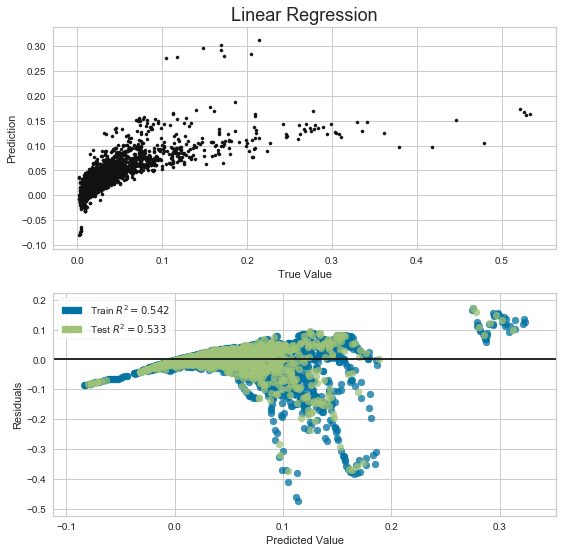

In [9]:
lm = LinearRegression()
lm.fit(X_train,y_train)
#y_train_pred=lm.predict(X_train_scale)
y_lm_val= lm.predict(X_val)
print(lm.coef_)
#print("The calculated RMSE for Linear Regression is:%0.8f" % (sqrt(mean_squared_error(y_val_vp, y_lm_val_vp))))
#MARD_lm_vp=np.median(np.absolute(y_lm_val_vp-y_val_vp)/(y_val_vp))
#print("The median absolute relative deviation is %.4f "% (MARD_lm_vp))
#r2_lm_vp = r2_score(y_val_vp, y_lm_val_vp)
#print("The R squared  is %.4f "% (r2_lm_vp))

The calculated RMSE forLinear Regression is:0.03481049
The median absolute relative deviation is 0.4220 
The R squared  is 0.5329 


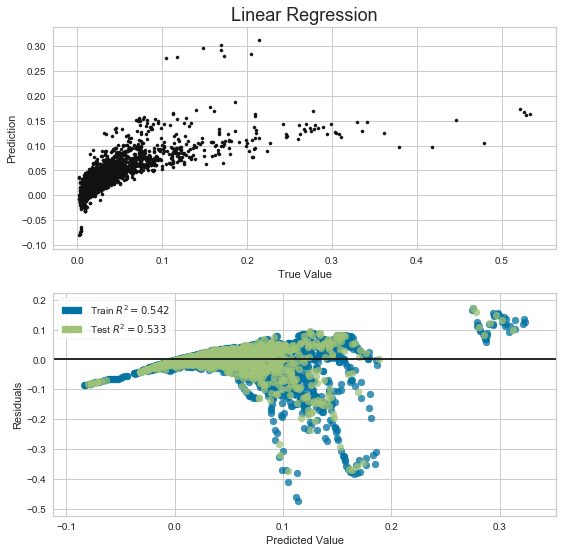

In [25]:
model_name='Linear Regression'
MARD_lm=score(model_name,y_val,y_lm_val)
title=model_name+' Far Field'
plot_result(lm,model_name,title,X_train,y_train,X_val,y_val,y_lm_val)

### Polynomial Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The calculated RMSE forPolynomial Regression is:0.02785882
The median absolute relative deviation is 0.3271 
The R squared  is 0.7008 


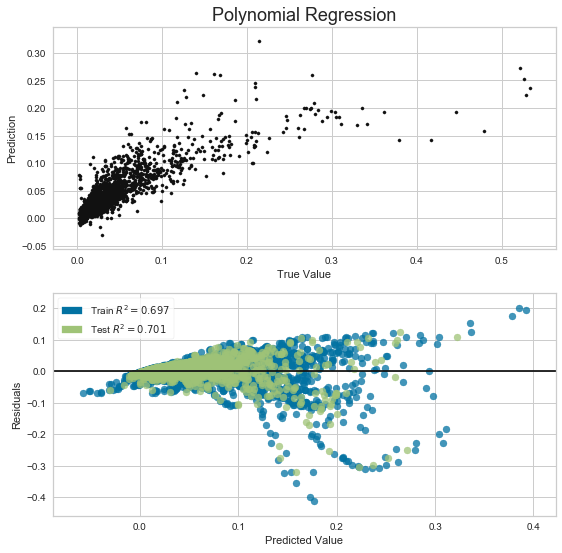

In [10]:
d=2
polynomial_features= PolynomialFeatures(degree=d)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_val = polynomial_features.fit_transform(X_val)
poly = LinearRegression()
poly.fit(x_poly_train,y_train)
y_poly_val = poly.predict(x_poly_val)

model_name='Polynomial Regression'
MARD_poly=score(model_name,y_val,y_poly_val)
title=model_name+' Far Field'
plot_result(poly,model_name,title,x_poly_train,y_train,x_poly_val,y_val,y_poly_val)

### Kernel Ridge Regression

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-05, 5.62341325e-05, 3.16227766e-04, 1.77827941e-03,
       1.00000000e-02]),
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best estimator found by grid search:
{'alpha': 0.0017782794100389228, 'gamma': 10.0}
The calculated RMSE forKernel Ridge Regression is:0.03481049
The median absolute relative deviation is 0.4220 
The R squared  is 0.5329 


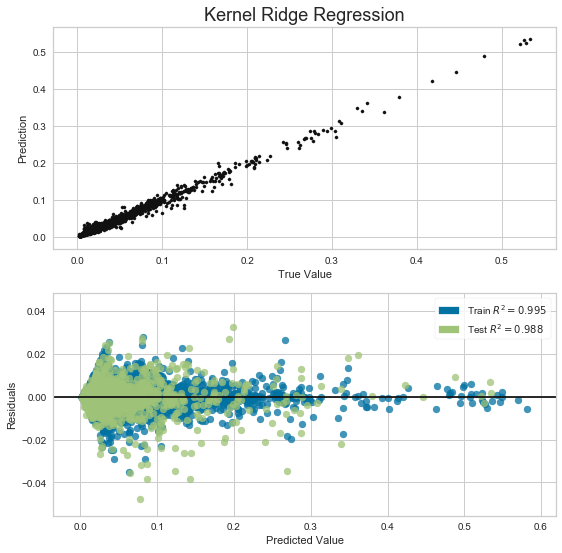

In [11]:
param_grid_kr ={"alpha": np.logspace(-5,-2,5),"gamma": np.logspace(-2,2,5)}
kr = GridSearchCV(estimator=KernelRidge(kernel='rbf'),param_grid=param_grid_kr, cv=5)
#kr=KernelRidge(alpha=0.0001,gamma=10.0)
kr.fit(X_train, y_train)
y_kr_val = kr.predict(X_val)
print("Best estimator found by grid search:")
print(kr.best_params_)

model_name='Kernel Ridge Regression'
MARD_kr=score(model_name,y_val,y_kr_val)
title=model_name+' Far Field'
plot_result(kr,model_name,title,X_train,y_train,X_val,y_val,y_kr_val)

In [90]:
MARD_kr=score(model_name,y_val,y_kr_val)

The calculated RMSE for Linear Regression is:0.00547343
The median absolute relative deviation is 0.0835 
The R squared  is 0.9885 


### Support Vector Regression

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'epsilon': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Support vector ratio: 0.706
Best estimator found by grid search:
{'C': 10.0, 'epsilon': 0.001, 'gamma': 10.0}
The calculated RMSE forSupport Vector Regression is:0.00564888
The median absolute relative deviation is 0.0775 
The R squared  is 0.9877 


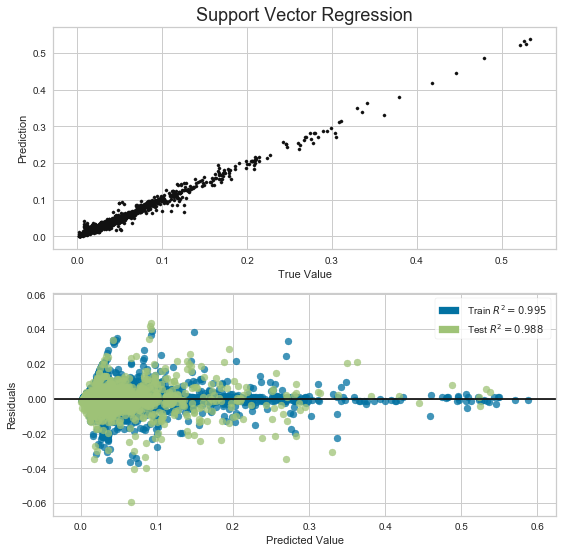

In [12]:
param_grid_svr={"C": np.logspace(-2, 2, 5),"gamma": np.logspace(-2, 2, 5), "epsilon": [0.0001,0.001, 0.01, 0.1]}
svr = GridSearchCV(SVR(kernel='rbf',cache_size=1000),param_grid_svr ,cv=5)

svr.fit(X_train, y_train)

sv_ratio = svr.best_estimator_.support_.shape[0] / X_train.shape[0]
print("Support vector ratio: %.3f" % sv_ratio)

y_svr_val = svr.predict(X_val)
print("Best estimator found by grid search:")
print(svr.best_params_)

model_name='Support Vector Regression'
MARD_svr=score(model_name,y_val,y_svr_val)
title=model_name+' Far Field'
plot_result(svr,model_name,title,X_train,y_train,X_val,y_val,y_svr_val)

### Gradient Boosting Machine

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=9, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The calculated RMSE forGradient Boosting Regression is:0.00556776
The median absolute relative deviation is 0.0770 
The R squared  is 0.9880 


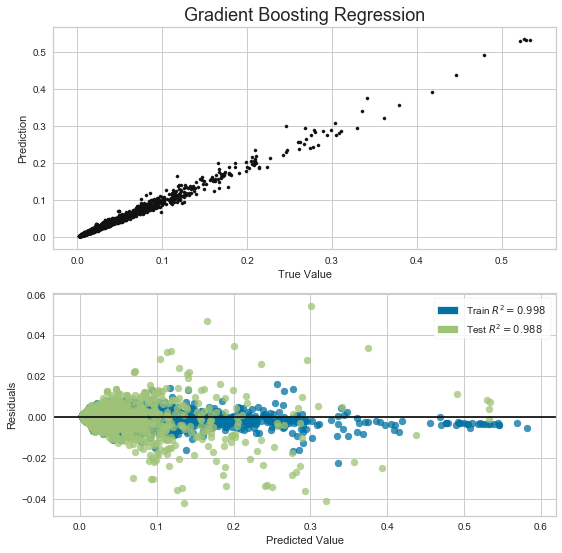

In [15]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(random_state=9,**params)
gbr.fit(X_train, y_train)
y_gbr_val= gbr.predict(X_val)


model_name='Gradient Boosting Regression'
MARD_gbr=score(model_name,y_val,y_gbr_val)
title=model_name+' Far Field'
plot_result(gbr,model_name,title,X_train,y_train,X_val,y_val,y_gbr_val)

### Random Forest Regression

In [16]:
regressor = RandomForestRegressor(random_state=9,oob_score=True)
parameters = [{'max_features' : ['auto','sqrt','log2'],'n_estimators' : [10,20,40,60,80,100],'max_depth':[5,10,15,20,25,30]}]
rf = GridSearchCV(estimator = regressor, param_grid = parameters)
rf.fit(X_train, y_train)
best_parameters = rf.best_params_
# Best paramete set
print('Best parameters found:\n', best_parameters)
y_rf_val= rf.predict(X_val)

c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\wangdong90\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs d

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=9,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

Best parameters found:
 {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}


The calculated RMSE forRandom Forest Regression is:0.00613938
The median absolute relative deviation is 0.0604 
The R squared  is 0.9855 


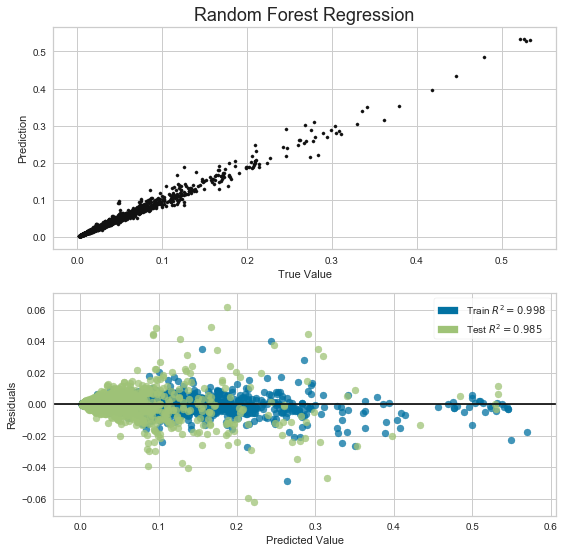

In [17]:
model_name='Random Forest Regression'
MARD_rf=score(model_name,y_val,y_rf_val)
title=model_name+' Far Field'
plot_result(rf,model_name,title,X_train,y_train,X_val,y_val,y_rf_val)

In [44]:
ARD_lm=score(model_name,y_val,y_lm_val)
ARD_poly=score(model_name,y_val,y_poly_val)
ARD_kr=score(model_name,y_val,y_kr_val)
ARD_svr=score(model_name,y_val,y_svr_val)
ARD_gbr=score(model_name,y_val,y_gbr_val)
ARD_rf=score(model_name,y_val,y_rf_val)

The calculated RMSE for Linear Regression is:0.03481049
The median absolute relative deviation is 0.4220 
The R squared  is 0.5329 
The calculated RMSE for Linear Regression is:0.02785882
The median absolute relative deviation is 0.3271 
The R squared  is 0.7008 
The calculated RMSE for Linear Regression is:0.00547343
The median absolute relative deviation is 0.0835 
The R squared  is 0.9885 
The calculated RMSE for Linear Regression is:0.00564888
The median absolute relative deviation is 0.0775 
The R squared  is 0.9877 
The calculated RMSE for Linear Regression is:0.00556776
The median absolute relative deviation is 0.0770 
The R squared  is 0.9880 
The calculated RMSE for Linear Regression is:0.00613938
The median absolute relative deviation is 0.0604 
The R squared  is 0.9855 


## T-test

In [57]:
columns = ["Linear Regression", "Polynomial Regression", "Kernel Ridge Regression","Support Vector Regression","Gradient Boosting Regression","Random Forest Regression"]
data = np.array([ARD_lm, ARD_poly,ARD_kr,ARD_svr,ARD_gbr,ARD_rf])
data=data.transpose()
ARD_far_field = pd.DataFrame(data=data, columns=columns)
ARD_far_field.head()
ARD_far_field.to_csv (r'ARD_Far_Field.csv', index = False, header=True)
ARD_near_fault=pd.read_csv('ARD_Near_Fault.csv',header=[0])
ARD_near_fault.head()
print("The number of data for near fault motions:{}".format(ARD_near_fault.shape[0]))
print("The number of data for far field motions:{}".format(ARD_far_field.shape[0]))

,Linear Regression,Polynomial Regression,Kernel Ridge Regression,Support Vector Regression,Gradient Boosting Regression,Random Forest Regression
0,0.582171,0.589932,0.049690,0.011177,0.101422,0.089840
1,0.054364,0.284756,0.075671,0.082693,0.015591,0.000358
2,0.974527,0.772299,0.004611,0.063896,0.062073,0.001212
3,0.609642,0.372916,0.008173,0.000268,0.018334,0.016091
4,0.061882,0.712520,0.090233,0.072409,0.074620,0.065654


<Figure size 864x432 with 0 Axes>

[None, None, None, None, None, None, None, None, None, None, None, None]

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

Text(0.5, 1.0, 'Near-Fault Ground Motion')

Text(0, 0.5, 'ARD')

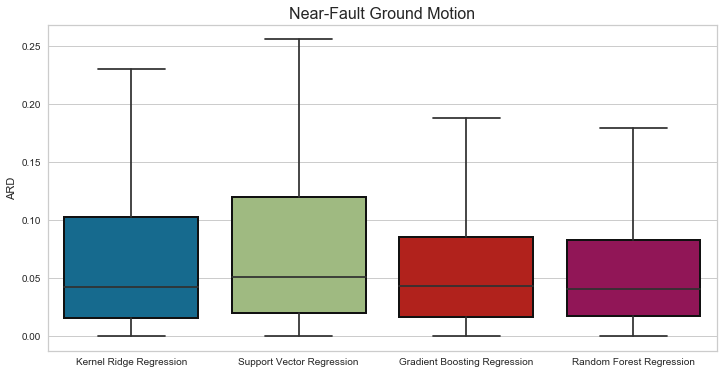

In [95]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(data=ARD_near_fault[["Kernel Ridge Regression","Support Vector Regression","Gradient Boosting Regression","Random Forest Regression"]],showfliers = False)
plt.setp(ax.artists, alpha=1, linewidth=2, edgecolor="k")
plt.xticks(rotation=0)
ax.set_title('Near-Fault Ground Motion',fontsize=16)
ax.set_ylabel('ARD')
plt.savefig("ARD_Near_Fault"+ ".eps")
plt.savefig("ARD_Near_Fault"+ ".png")

<Figure size 864x432 with 0 Axes>

[None, None, None, None, None, None, None, None, None, None, None, None]

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

Text(0.5, 1.0, 'Far-Field Ground Motion')

Text(0, 0.5, 'ARD')

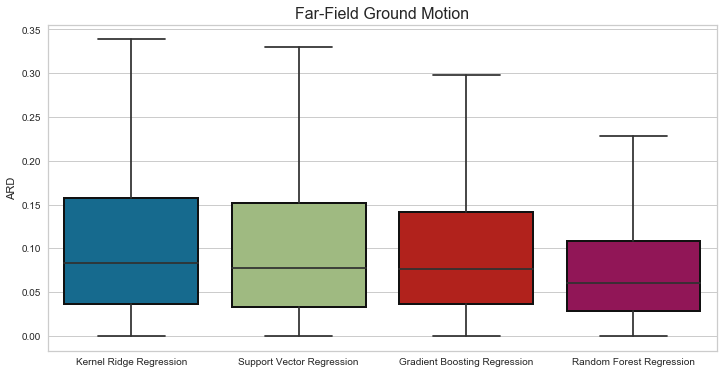

In [96]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(data=ARD_far_field[["Kernel Ridge Regression","Support Vector Regression","Gradient Boosting Regression","Random Forest Regression"]],showfliers = False)
plt.setp(ax.artists, alpha=1, linewidth=2, edgecolor="k")
plt.xticks(rotation=0)
ax.set_title('Far-Field Ground Motion',fontsize=16)
ax.set_ylabel('ARD')
plt.savefig("ARD_Far_Field"+ ".eps")
plt.savefig("ARD_Far_Field"+ ".png")

In [89]:
def t_test(a,b):
    var_a = a.var(ddof=1)
    var_b = b.var(ddof=1)
    n=len(a)
    m=len(b)
    s=np.sqrt(((n-1)/(m+n-2)*var_a + (m-1)/(m+n-2)*var_b))
    t = (a.mean() - b.mean())/(s*np.sqrt(1/n+1/m))
    df = m + n - 2
    if t>0:
        p = 2*(1 - stats.t.cdf(t,df=df))
    else:
        p = 2*stats.t.cdf(t,df=df)
    return (t,p)

ML_model=["Kernel Ridge Regression","Support Vector Regression","Gradient Boosting Regression","Random Forest Regression"]
t=[]
p=[]
for col in ML_model:
    a = ARD_near_fault[col].tolist()
    b = ARD_far_field[col].tolist()
    temp1,temp2=stats.ttest_ind(a,b)
    t.append(temp1)
    p.append(temp2)
p

[8.58662989921886e-08,
 5.4021725121974174e-05,
 2.771405777302789e-27,
 4.258647448873929e-06]

|Regression Model| Kernel Ridge | Support Vector | Gradient Boosting | Random Forest |
|--- | --- | ---| ---|---|
|p_value|8.6e-8|5.4e-5|2.8e-27|4.3e-6|